http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

In [1]:
from __future__ import division
import tensorflow as tf
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

In [2]:
from tensorflow.python.client import device_lib
#https://www.tensorflow.org/how_tos/using_gpu/
#https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow#_=_
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def get_all_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

In [3]:
get_available_gpus()

[]

In [4]:
get_all_available_devices()

[u'/cpu:0']

In [5]:
print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
('- learns neither dependency:', 0.66156323815798213)
('- learns first dependency:  ', 0.51916669970720941)
('- learns both dependencies: ', 0.4544543674493905)


it turns out that backpropagating errors over too many time steps often causes them to vanish (become insignificantly small) or explode (become overwhelmingly large)

In [6]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

In [7]:
X, Y = gen_data(10)
X, Y

(array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0]), array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1]))

In [8]:
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

In [9]:
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [10]:
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4      #each state is represented with a certain width, a vector
learning_rate = 0.1

In [11]:
tf.reset_default_graph()

In [12]:
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

In [13]:
x.get_shape()

TensorShape([Dimension(200), Dimension(5)])

In [14]:
x_one_hot = tf.one_hot(x, num_classes)  #this is some preprocessing useful for this case only
                                        #I guess he wants to play with more than two classes (other than binary)

x_one_hot.get_shape()

TensorShape([Dimension(200), Dimension(5), Dimension(2)])

In [15]:
rnn_inputs = tf.unpack(x_one_hot, axis=1)
rnn_inputs

[<tf.Tensor 'unpack:0' shape=(200, 2) dtype=float32>,
 <tf.Tensor 'unpack:1' shape=(200, 2) dtype=float32>,
 <tf.Tensor 'unpack:2' shape=(200, 2) dtype=float32>,
 <tf.Tensor 'unpack:3' shape=(200, 2) dtype=float32>,
 <tf.Tensor 'unpack:4' shape=(200, 2) dtype=float32>]

So here we have a list of five inputs that all(?) are going to play a role in back propagation ??

Anyway the important thing is that we have the inputs, or each input each batch, split into the num_steps, number of steps

So the final input are 5 separate of them (we chose n=5 above)  
and the fact that they have one hot encoding and they have a dimension of two is only related to this particular problem

In [16]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py
"""

with tf.variable_scope('rnn_cell'):
    #in other words we have the X coming from below which here is num_classes = 2 (it is binary in this case)
    #and we also have the state size which is coming from the left
    #(previous step in time or just zeros if we are at t=0)
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    
    #Well some outputs of the rnn cell are going to the next node at the right.
    #These outputs are connected to the next node at the right and of course they have a size of state_size
    #as we have defined ourselves as a hyperparameter
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

In [17]:
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        
    
    return tf.tanh(tf.matmul(
            tf.concat(1, [rnn_input, state]), W
            #concat dimension, inputs, so you see that both the state and the inputs are being treated as one
        ) + b)
    #non linearity chosen here is tanh

In [18]:
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
    
#as we see here the outputs are the state outputs of each rnn.
#But here we have set the dimensionality to an arbitrary number of 4, right? so how is this converted back to dim 2?

final_state = rnn_outputs[-1]

#We just keep the final of the ouputs in a separate variable

In [19]:
#so here is the solution, we define these W and b variables only once.
#Meaning that the weights and biases are shared for ALL of these rnn_outputs
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

In [20]:
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
[logit.get_shape() for logit in logits] #these are the logits for the outputs

[TensorShape([Dimension(200), Dimension(2)]),
 TensorShape([Dimension(200), Dimension(2)]),
 TensorShape([Dimension(200), Dimension(2)]),
 TensorShape([Dimension(200), Dimension(2)]),
 TensorShape([Dimension(200), Dimension(2)])]

In [21]:
#To get the predictions for each class we can simply use the softmax function
preds = [tf.nn.softmax(logit) for logit in logits] #these are the logits for the outputs
preds[0].get_shape()

TensorShape([Dimension(200), Dimension(2)])

In [22]:
#tf.nn.softmax_cross_entropy_with_logits
#tf.squeeze()
#processing of the targets
print y.get_shape()

#we just get our outputs that we have in a 200x5 fashion and we create 5 separate instances to compare against
#each output of the rnn network
y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(1, num_steps, y)]
y_as_list[0].get_shape()

(200, 5)


TensorShape([Dimension(200)])

In [23]:
#here we get all losses for all outputs (logits, before they be through softmax) and with the targets
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logit, label) for logit, label in zip(logits, y_as_list)]

In [24]:
total_loss = tf.reduce_mean(losses) #we treat all kind of losses equally so we have the total loss here

In [25]:
#train step as always we try to minimize the error with some optimizer
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [26]:
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('\nEPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.60203327000141149)
('Average loss at step', 200, 'for last 250 steps:', 0.56343717157840734)
('Average loss at step', 300, 'for last 250 steps:', 0.54757148921489718)
('Average loss at step', 400, 'for last 250 steps:', 0.52425423651933667)
('Average loss at step', 500, 'for last 250 steps:', 0.51918603748083114)
('Average loss at step', 600, 'for last 250 steps:', 0.52192204833030698)
('Average loss at step', 700, 'for last 250 steps:', 0.52050499647855764)
('Average loss at step', 800, 'for last 250 steps:', 0.52384610921144481)
('Average loss at step', 900, 'for last 250 steps:', 0.52016591697931291)


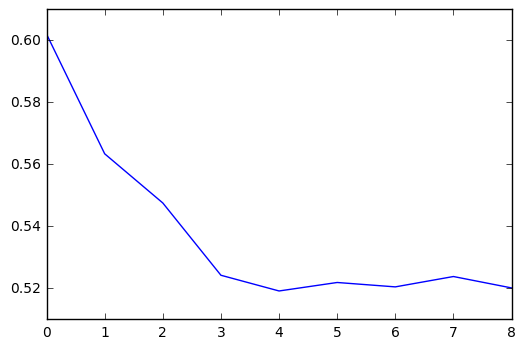

In [27]:
training_losses = train_network(1,num_steps)

plt.plot(training_losses)